In [6]:
from tqdm import tqdm
from datetime import datetime, timedelta
from collections import OrderedDict
from typing import Dict, Literal
from copy import deepcopy

from attrs import define
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.constants import DATA_DIR_PATH, WEEKDAYS, NEW_COLUMNS

DATE, TIME, GENERAL_PARKING, DBS_PARKING = NEW_COLUMNS
print(DATE, TIME, GENERAL_PARKING, DBS_PARKING)

date time general_parking dbs_parking


TODOs

- Generarme un .csv con los datos curados (uno por cada parking en caso de que quiera eliminar ciertos dias por no aportar info)

- Añadir los datos limpios al servidor, a una nueva tabla (clean_all_data_and_send_to_server.py)

- Crear un script de automatizacion de limpieza de datos para cada día, que se ejecute tras recavar todos los datos (daily_clean_and_send_to_server.py)

- Los siguientes pasos serían el automatizar la visualizacion de los datos y el obtener estadisticas de ellos:
    - Listado de días faltantes
    - Listado de días cuya info no cambia
    - Consultar el curso para ver posibles formas de visualizar y crear estadisticas
    - Consultar a compis sobre visualizaciones y calculos estadisticos que se pueden hacer al respecto

# Classes and Functions

In [7]:
@define
class OneDayTimeSeries:
    date: str
    df: pd.DataFrame
    its_empty: Dict[str, bool]  # No data available for the day
    has_missing_data: Dict[str, bool]  # Day has data but some of it is missing
    has_meaningful_data: Dict[str, bool]  # Day has data that provides meaningful information

    def __init__(self, date, its_empty, df, has_meaningful_data=None):
        self.date = date
        self.its_empty = its_empty
        self.has_missing_data = None
        self.df = df
        self.has_missing_data = self.check_missing_data()
        self.check_meaningful_data_format_and_assign_to_attribute(has_meaningful_data)


    def check_missing_data(self) -> Dict[str, bool]:
        """
        Returns True if the dataframe has missing data, False otherwise
        """
        # Check if the dataframe has missing data
        has_missing_data = {
            GENERAL_PARKING: False,
            DBS_PARKING: False
        }
        for k in has_missing_data.keys():
            if self.df[k].isnull().values.any():
                has_missing_data[k] = True
        return has_missing_data
    
    def check_meaningful_data_format_and_assign_to_attribute(self, has_meaningful_data) -> Dict[str, bool]:
        """
        
        """
        if has_meaningful_data is None:
            self.has_meaningful_data = {GENERAL_PARKING: True, DBS_PARKING: True}
        else:
            assert isinstance(has_meaningful_data, dict)
            for k in has_meaningful_data.keys():
                assert k in [GENERAL_PARKING, DBS_PARKING], "Wrong key in has_meaningful_data"
            self.has_meaningful_data = has_meaningful_data

    def __repr__(self):
        return f"OneDayTimeSeries(date={self.date}, its_empty={self.its_empty}, has_missing_data={self.has_missing_data}, has_meaningful_data={self.has_meaningful_data}, df={self.df.head()})"

In [8]:
def correct_time_format(row):
    """
    Corrects the error on the time column in which some rows do not
    have the miliseconds
    """
    splited = row.split('.')
    if len(splited) > 1:
        return splited[0]    
    return splited[0]

def check_days_with_missing_data(data: OrderedDict):
    """
    Prints the days with missing data
    """
    for d in data.values():
        for parking, has_missing_data in d.has_missing_data.items():
            if has_missing_data and not d.its_empty[parking]:
                number_of_missings = len(d.df.loc[d.df[parking].isna()])
                print(f'Day {d.date} has {number_of_missings} missings for {parking}')

In [9]:
def get_current_day_df_with_minute_freq(df_current_day: pd.DataFrame, timerange: pd.DatetimeIndex)-> pd.DataFrame:
    """
    Returns a dataframe with the minute frequency for the current day
    """
    current_day_info = []
    
    for t in timerange[:-1]:
        # We set the expand minutes to 0, to look for the current minute only
        # for the moment
        expand_minutes = 0

        # For every minute, we get all the records and take the minimum
        current_minute = t.strftime('%H:%M:%S')
        next_minute = (t + timedelta(minutes=1)).strftime('%H:%M:%S')
        
        df_current_minute = df_current_day.between_time(current_minute, next_minute, inclusive='left')

        # In case no data is available for the current minute, we take the
        # info from other minutes
        if df_current_minute.empty:
            # We take the median of the closest minutes if we have no data for 
            # the current minute
            expand_minutes = 1
            while expand_minutes < 10:  # Expand minutes is a hyperparameter
                # We expand the minutes to the left
                prev_minute = (t - timedelta(minutes=expand_minutes)).strftime('%H:%M:%S')
                posterior_minute = (t + timedelta(minutes=expand_minutes)).strftime('%H:%M:%S')
                df_minutes_prev = df_current_day.between_time(prev_minute, next_minute, inclusive='left')
                df_minutes_next = df_current_day.between_time(current_minute, posterior_minute, inclusive='left')
                if df_minutes_prev.empty and not df_minutes_next.empty:
                    df_current_minute = df_minutes_next
                    # In case not minutes back are available, we take the next
                    # This case will only happen in the first minute of the day
                    # We take the minimum of the minutes next
                    '''
                    print('------------------')
                    print('Mins next not empty')
                    print('Mins prev:', df_minutes_prev)
                    print('Mins next:', df_minutes_next)
                    print('------------------')
                    df_current_minute[GENERAL_PARKING] = df_minutes_next[GENERAL_PARKING]
                    df_current_minute[DBS_PARKING] = df_minutes_next[DBS_PARKING]
                    '''
                    break
                
                elif not df_minutes_prev.empty and df_minutes_next.empty:
                    # In case no minutes next are available, we take the previous
                    # This case would be the usual case when the server is down
                    # for 2 to 10 minutes throughout the day
                    df_current_minute = df_minutes_prev
                    '''
                    print('------------------')
                    print('Mins prev not empty')
                    print('Mins prev:', df_minutes_prev)
                    print('Mins next:', df_minutes_next)

                    print('Minimum of 1 value GENERAL:', df_minutes_prev[GENERAL_PARKING])
                    print('Minimum of 1 value BOTH:', df_minutes_prev)
                    
                    # df_current_minute[GENERAL_PARKING] = df_minutes_prev[GENERAL_PARKING].min()
                    # df_current_minute[DBS_PARKING] = df_minutes_prev[DBS_PARKING].min()
                    '''
                    break

                elif not df_minutes_prev.empty and not df_minutes_next.empty:
                    # In case both are available, we take the min of both
                    # This would be the usual case when the server is down
                    # only for 1 minute throughout the day
                    # TODO: Maybe this case is not necessary, so we should test
                    #   it and remove it if it is not necessary
                    df_combined = pd.concat([df_minutes_prev, df_minutes_next])
                    df_current_minute = df_combined
                    '''
                    general_combined = pd.concat([df_minutes_prev[GENERAL_PARKING], df_minutes_next[GENERAL_PARKING]])
                    dbs_combined = pd.concat([df_minutes_prev[DBS_PARKING], df_minutes_next[DBS_PARKING]])
                    print('------------------')
                    print('Both combined:', df_combined)
                    print('General_combined:', general_combined)
                    print('DBS_combined:', dbs_combined)
                    print('------------------')
                    df_current_minute[GENERAL_PARKING] = general_combined
                    df_current_minute[DBS_PARKING] = dbs_combined
                    '''
                    break

                # In case no minutes backward nor next are available, we continue searching
                else:
                    expand_minutes += 1
            
            # TODO: This has to be included in a log
            if expand_minutes == 15:
                # print(f'No data available for {t} even after expanding 15 minutes before/after')
                pass

        if 15 > expand_minutes >= 1:
            # print(f'No data available for {t} but we found data {expand_minutes} minutes before/after')
            # print('General:', df_current_minute[GENERAL_PARKING])
            # print('DBS:', df_current_minute[DBS_PARKING])
            pass

        current_day_info.append(df_current_minute.min().to_list())
    
    # We add the last minute
    current_day_info.append(current_day_info[-1])

    return current_day_info

# Import the data

In [5]:
from utils.constants import RAW_MERGED_DATA_DIR_PATH
import os
import pandas as pd
from tqdm import tqdm
from time import perf_counter
def read_data_from_merged_csvs():
    # This sort is to ensure data is introduced from oldest to newest
    data_files = os.listdir(RAW_MERGED_DATA_DIR_PATH)
    data_files.sort()
    all_dfs = []
    for file in tqdm(data_files):
        all_dfs.append(pd.read_csv(RAW_MERGED_DATA_DIR_PATH / file, sep=';', index_col=0))
    df = pd.concat(all_dfs)

    return df

df_prueba = read_data_from_merged_csvs()
df_prueba

  0%|          | 0/410 [00:00<?, ?it/s]

100%|██████████| 410/410 [00:15<00:00, 26.84it/s]


Time 1: 15.310583900000012


100%|██████████| 411/411 [00:02<00:00, 152.24it/s]


Time 2: 2.811688800000013


,date,time,general_parking,dbs_parking
0,2022-04-11,10:05:19.338571,0,16
1,2022-04-11,10:05:34.746900,0,16
2,2022-04-11,10:05:49.991718,0,16
3,2022-04-11,10:06:05.206539,0,16
4,2022-04-11,10:06:20.440398,0,16
...,...,...,...,...
3281,2023-06-23,20:28:46.562028,99,0
3282,2023-06-23,20:29:01.803656,99,0
3283,2023-06-23,20:29:17.025011,99,0
3284,2023-06-23,20:29:32.260995,99,0


In [10]:
df_all_data = pd.read_csv(DATA_DIR_PATH / 'curated/all_data.csv', sep=';', index_col=0)
df = df_all_data.copy()
df

,date,time,general_parking,dbs_parking
0,2022-04-13,06:30:18.999185,138,0
1,2022-04-13,06:30:34.258286,138,0
2,2022-04-13,06:30:49.498356,138,0
3,2022-04-13,06:31:04.731729,138,0
4,2022-04-13,06:31:19.965184,138,0
...,...,...,...,...
1599254,2023-09-28,20:28:57.182679,96,0
1599255,2023-09-28,20:29:12.450405,96,0
1599256,2023-09-28,20:29:27.717029,96,0
1599257,2023-09-28,20:29:42.972124,96,0


We remove the miliseconds as they are not important

In [6]:
df.time = df.time.apply(correct_time_format)
df

,date,time,general_parking,dbs_parking
0,2022-04-13,06:30:18,138,0
1,2022-04-13,06:30:34,138,0
2,2022-04-13,06:30:49,138,0
3,2022-04-13,06:31:04,138,0
4,2022-04-13,06:31:19,138,0
...,...,...,...,...
1599254,2023-09-28,20:28:57,96,0
1599255,2023-09-28,20:29:12,96,0
1599256,2023-09-28,20:29:27,96,0
1599257,2023-09-28,20:29:42,96,0


# Clean the data

Now we need to reduce the data to the following characteristics:
- Resolution or freq of 1 minute
- When more than 1 measurement is present in one minute and they differ, we take the maximum occupation or the minimum space available
- We want data to be from 6:30 in the morning till 20:30 in the evening 

## Date and time set as index

In [99]:
# This code sets the index to datetime
df.time = df.time.apply(correct_time_format)
df['datetime'] = df.date + ' ' + df.time
df.datetime = pd.to_datetime(df.datetime, format='%Y-%m-%d %H:%M:%S')
df = df.drop([DATE, TIME], axis=1)
df = df[['datetime', GENERAL_PARKING, DBS_PARKING]]
df = df.set_index("datetime")
df

,general_parking,dbs_parking
datetime,,
2022-04-13 06:30:18,138,0
2022-04-13 06:30:34,138,0
2022-04-13 06:30:49,138,0
2022-04-13 06:31:04,138,0
2022-04-13 06:31:19,138,0
...,...,...
2023-09-28 20:28:57,96,0
2023-09-28 20:29:12,96,0
2023-09-28 20:29:27,96,0


Generate an Object for each day that contains info about it apart from the actual data, so that cleaning is easier

In [8]:
# Create a list with the object of time series for each day
start_date = df.index[0]
end_date = df.index[len(df.index)-1]
daterange = pd.date_range(start_date.date(), end_date.date())
all_data = OrderedDict()
its_empty_true = {
    GENERAL_PARKING: True,
    DBS_PARKING: True
}
its_empty_false = {
    GENERAL_PARKING: False,
    DBS_PARKING: False
}

# Iterate over the days
for d in tqdm(daterange):
    current_day_found = 0
    current_day = d.date().strftime('%Y-%m-%d')
    timerange = pd.date_range(f'{current_day} 06:30:00', f'{current_day} 20:30:00', freq='min')
    df_current_day = df.loc[current_day]
    
    if df_current_day.empty:
        all_data[current_day] = OneDayTimeSeries(
            date=current_day,
            its_empty=deepcopy(its_empty_true),  # deepcopy is necessary to avoid being all references to the same object
            df=pd.DataFrame(columns=[GENERAL_PARKING, DBS_PARKING])
        )
        
    else:
        # If found, we must get a df with a freq of minutes from 
        # 06:30:00 to 20:30:00
        current_day_data = get_current_day_df_with_minute_freq(df_current_day, timerange)
        all_data[current_day] = OneDayTimeSeries(
            date=current_day,
            its_empty=deepcopy(its_empty_false), # deepcopy is necessary to avoid being all references to the same object
            df=pd.DataFrame(data=current_day_data, index=timerange, columns=[GENERAL_PARKING, DBS_PARKING])
        )

# Check days with missing data
for d in all_data.values():
    for parking in d.has_missing_data.keys():
        if d.has_missing_data[parking]:
            print(f'Day {d.date} has missing data for {parking}')

  0%|          | 0/534 [00:00<?, ?it/s]

100%|██████████| 534/534 [03:10<00:00,  2.80it/s]

Day 2022-07-07 has missing data for general_parking
Day 2022-07-07 has missing data for dbs_parking
Day 2023-03-02 has missing data for general_parking
Day 2023-03-02 has missing data for dbs_parking
Day 2023-05-16 has missing data for general_parking
Day 2023-05-16 has missing data for dbs_parking
Day 2023-06-11 has missing data for general_parking
Day 2023-06-11 has missing data for dbs_parking
Day 2023-08-14 has missing data for general_parking
Day 2023-08-14 has missing data for dbs_parking
Day 2023-08-17 has missing data for general_parking
Day 2023-08-17 has missing data for dbs_parking
Day 2023-08-24 has missing data for general_parking
Day 2023-08-24 has missing data for dbs_parking
Day 2023-08-25 has missing data for general_parking
Day 2023-08-25 has missing data for dbs_parking


In [9]:
all_data_raw = deepcopy(all_data)  # In case we destroy all_data, we have a backup

### Check days that have incomplete data

In [10]:
check_days_with_missing_data(all_data)

Day 2022-07-07 has 190 missings for general_parking
Day 2022-07-07 has 190 missings for dbs_parking
Day 2023-03-02 has 74 missings for general_parking
Day 2023-03-02 has 74 missings for dbs_parking
Day 2023-05-16 has 393 missings for general_parking
Day 2023-05-16 has 393 missings for dbs_parking
Day 2023-06-11 has 698 missings for general_parking
Day 2023-06-11 has 698 missings for dbs_parking
Day 2023-08-14 has 663 missings for general_parking
Day 2023-08-14 has 663 missings for dbs_parking
Day 2023-08-17 has 165 missings for general_parking
Day 2023-08-17 has 165 missings for dbs_parking
Day 2023-08-24 has 101 missings for general_parking
Day 2023-08-24 has 101 missings for dbs_parking
Day 2023-08-25 has 111 missings for general_parking
Day 2023-08-25 has 111 missings for dbs_parking


As all of the displayed days have too much missings and the amount of days with missing data is low, we are just going to discard them

In [11]:
# Remove info from days with missing data
for d in all_data.values():
    for parking in d.has_missing_data.keys():
        if d.has_missing_data[parking]:
            d.df[parking] = pd.Series(name=parking)
            d.its_empty[parking] = True
            d.has_missing_data[parking] = False
            
check_days_with_missing_data(all_data)

## Inspect the data in search for more problems

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

First concatenate all the data into a single DF

In [13]:
def days_where_only_one_parking_has_no_data(data: OrderedDict):
    """
    Prints the days where only one parking has no data
    """
    for d in data.values():
        if d.its_empty[GENERAL_PARKING] and not d.its_empty[DBS_PARKING]:
            print(f'Day {d.date} has no data for {GENERAL_PARKING}')
        elif not d.its_empty[GENERAL_PARKING] and d.its_empty[DBS_PARKING]:
            print(f'Day {d.date} has no data for {DBS_PARKING}')

In [14]:
days_where_only_one_parking_has_no_data(all_data)

As both parkings have or do not have data at the same time, we can concatenate all in one dataframe

In [15]:
df_all_data_concat = pd.DataFrame(columns=[GENERAL_PARKING, DBS_PARKING])
for day in all_data.keys():

    if all_data[day].its_empty[GENERAL_PARKING]:
        continue
    else:
        df_all_data_concat = pd.concat([df_all_data_concat, all_data[day].df])

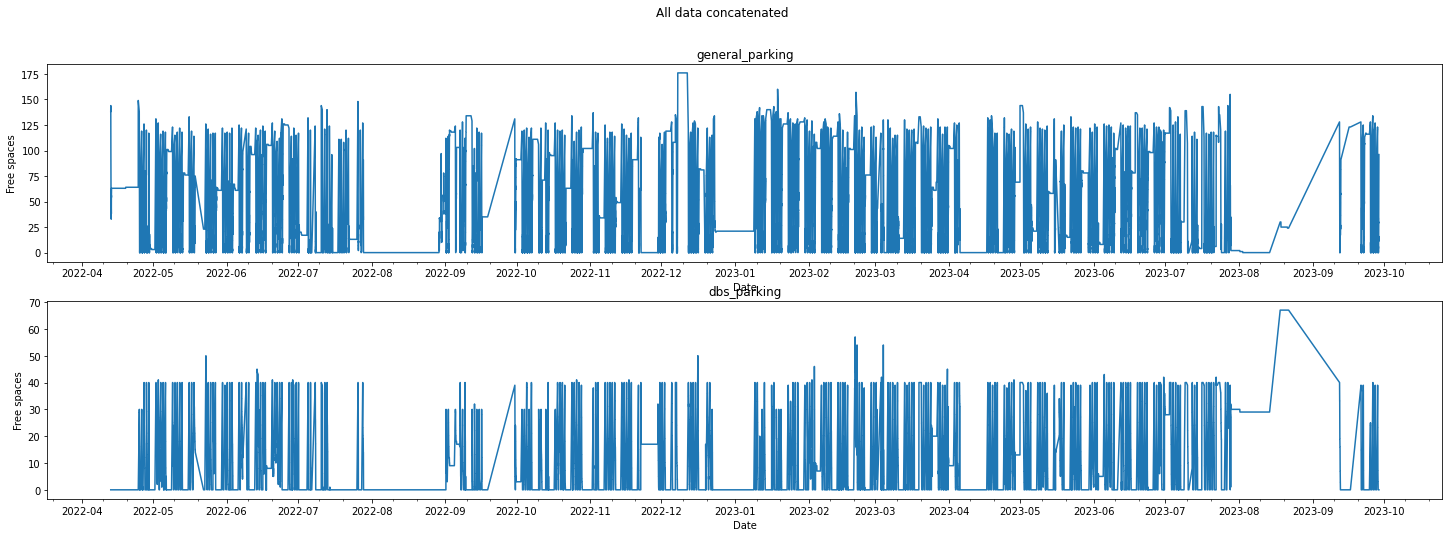

In [16]:
# Plot all data concatenated
fig, axes = plt.subplots(2,1, figsize=(25, 8))
fig.suptitle(f'All data concatenated')
for idx, col in enumerate(df_all_data_concat.columns):
    axes[idx].plot(df_all_data_concat.index, df_all_data_concat[col], label=col)
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Free spaces')
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator())
    axes[idx].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(10, 20)))
    # axes[idx].set_xlim([datetime(2022, 10, 1), datetime(2023, 7, 1)])
plt.show()

We can see how there are a lot of blank spaces

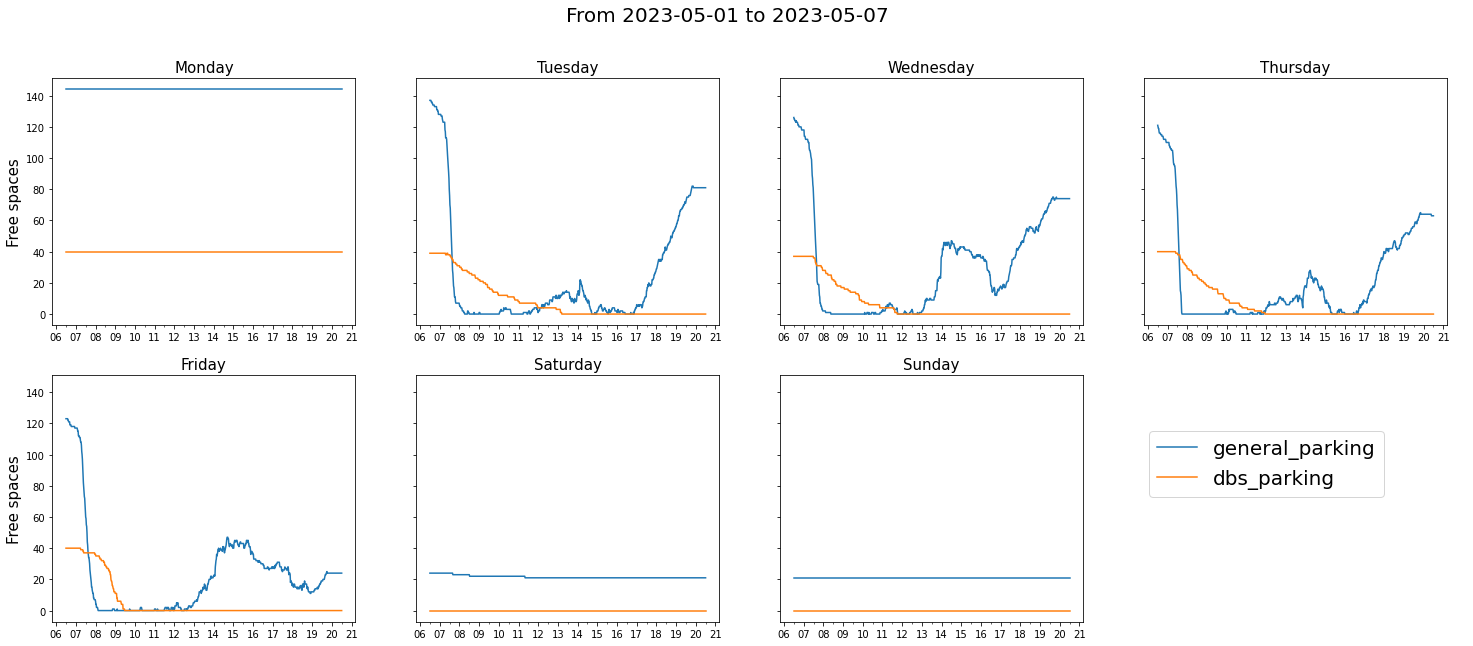

In [17]:
# Plot all days from a week
start, end = '2023-05-01', '2023-05-07'
daterange = pd.date_range(start, end)
width, height = 25, 10
fig, axes = plt.subplots(2,4, figsize=(25, 10), sharey=True)
fig.suptitle(f'From {start} to {end}', fontsize=20)
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if i != 1 or j != 3:
            d = daterange[i*4 + j]
            df_today = df_all_data_concat.loc[d.strftime('%D')]
            ax.plot(df_today.index, df_today)
            ax.set_title(WEEKDAYS[datetime.weekday(d)], fontsize=15)
            ax.xaxis.set_major_locator(mdates.HourLocator())
            ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=(30)))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
            if j == 0:
                ax.set_ylabel('Free spaces', fontsize=15)
        else:
            ax.remove()

fig.legend(df_today.columns, loc=(0.78, 0.23), fontsize=20)
plt.show()

This figure shows the problems with Weekends and some holydays like May the 1st (that they hold no info), so we have to clean this dates where no fluctuation on the occupation occur just to clean data

For cleaning this data, we should look for days where the change in occupation is below a threshold, as 10 spaces.

### Remove meaningless days

As exposed, there are days with flat data that are meaningless for predicting... So we must get rid of them. First inspect the extrange data to see what patters they have

In [18]:
def check_one_day_has_meaningless_data(one_day_data: OneDayTimeSeries, diff_threshold: int = 10) -> Dict[str, bool] or None:
    """
    Returns True if data is meaningless, False otherwise.
    Rules:
        #1: the difference between the minimum and maximum 
            occupation is less than diff_threshold
        #2: the difference between consecutive values is equal to 0 for 70% of the day
    """
    result = {}

    if one_day_data.its_empty[GENERAL_PARKING] and one_day_data.its_empty[DBS_PARKING]:
            return None
    
    elif one_day_data.its_empty[GENERAL_PARKING] and not one_day_data.its_empty[DBS_PARKING]:
        print(f'Day {day} has NO data ONLY for {GENERAL_PARKING}')
        raise Exception('This case is supposed to be handled by the previous code')
    
    elif not one_day_data.its_empty[GENERAL_PARKING] and one_day_data.its_empty[DBS_PARKING]:
        print(f'Day {day} has NO data ONLY for {DBS_PARKING}')
        raise Exception('This case is supposed to be handled by the previous code')        

    # When data avaialble for both parkings
    else:

        for col in one_day_data.df.columns:
    
            # Condition 1: Check if the difference between the minimum and maximum
            #   free spaces is less than diff_threshold
            min_occupation = one_day_data.df[col].min()
            max_occupation = one_day_data.df[col].max()
            diff = max_occupation - min_occupation
            if diff < diff_threshold:
                result[col] = True  # Meaningless data
            else:
                result[col] = False

            # Condition 2: Check if the difference between consecutive values is
            #   equal to 0 for 99% of the day. In such case, we consider that the
            #   data is meaningless
            number_of_datapoints = len(one_day_data.df[col])
            number_of_consecutive_equal_values = one_day_data.df[col].diff(periods=1).value_counts()[0]
            percent_of_consecutive_equal_values = number_of_consecutive_equal_values / number_of_datapoints
            #print(percent_of_consecutive_equal_values)
            if number_of_consecutive_equal_values / number_of_datapoints > 0.995:  # Value found by testing
                if diff > diff_threshold:
                    print(f'{one_day_data.date}: has {percent_of_consecutive_equal_values:.2f}% of consecutive equal values for {col}')
                result[col] = True
                
    return result

def mark_days_and_parking_as_containing_meaningless_data(data: OrderedDict, diff_threshold: int = 10):
    """
    Marks the days and the parking where the data is meaningless following some rules.
    args:
        data: OrderedDict with the data
        diff_threshold: threshold to consider that the data is meaningless
    returns:
        days_with_meaningful_data: Dict with the number of days with meaningful data
    """
    days_with_meaningful_data = {
        GENERAL_PARKING: 0,
        DBS_PARKING: 0
    }
    for day in data.keys():
        
        one_day_result = check_one_day_has_meaningless_data(data[day], diff_threshold)

        if one_day_result is not None:
            for k, v in one_day_result.items():
                if v:  # If data is meaningless, we mark meaningful as False
                    data[day].has_meaningful_data[k] = False
                    # print(f'{day}: Marked as containing meaningless data for {k}')
                else:  # If data is meaningful, we mark meaningful as True
                    data[day].has_meaningful_data[k] = True
                    days_with_meaningful_data[k] += 1
                    
    return days_with_meaningful_data

In [19]:
days_with_meaningful_data = mark_days_and_parking_as_containing_meaningless_data(all_data)

2022-04-24: has 1.00% of consecutive equal values for general_parking
2022-07-10: has 1.00% of consecutive equal values for general_parking
2022-07-10: has 1.00% of consecutive equal values for dbs_parking
2022-12-06: has 1.00% of consecutive equal values for general_parking
2022-12-06: has 1.00% of consecutive equal values for dbs_parking
2023-03-19: has 1.00% of consecutive equal values for dbs_parking
2023-04-30: has 1.00% of consecutive equal values for general_parking
2023-04-30: has 1.00% of consecutive equal values for dbs_parking
2023-06-18: has 1.00% of consecutive equal values for general_parking
2023-07-02: has 1.00% of consecutive equal values for general_parking
2023-07-02: has 1.00% of consecutive equal values for dbs_parking
2023-07-16: has 1.00% of consecutive equal values for general_parking
2023-07-16: has 1.00% of consecutive equal values for dbs_parking
2023-07-22: has 1.00% of consecutive equal values for dbs_parking


Now we make a list of those days with consecutive equal values and plot them

In [21]:
list_of_days_with_lots_of_consecutive_equal_values = []
for day in all_data.keys():
    for parking in all_data[day].has_meaningful_data.keys():
        if all_data[day].its_empty[parking]:
            continue
        number_of_consecutive_equal_values = all_data[day].df[col].diff(periods=1).value_counts()[0]
        number_of_datapoints = len(all_data[day].df[col])
        percent_of_consecutive_equal_values = number_of_consecutive_equal_values / number_of_datapoints
        if percent_of_consecutive_equal_values > 0.995:
            min_occupation = all_data[day].df[col].min()
            max_occupation = all_data[day].df[col].max()
            diff = max_occupation - min_occupation
            if diff > 10:
                list_of_days_with_lots_of_consecutive_equal_values.append(day)
list_of_days_with_lots_of_consecutive_equal_values

['2022-07-10',
 '2022-07-10',
 '2022-12-06',
 '2022-12-06',
 '2023-03-19',
 '2023-03-19',
 '2023-04-30',
 '2023-04-30',
 '2023-07-02',
 '2023-07-02',
 '2023-07-16',
 '2023-07-16',
 '2023-07-22',
 '2023-07-22']

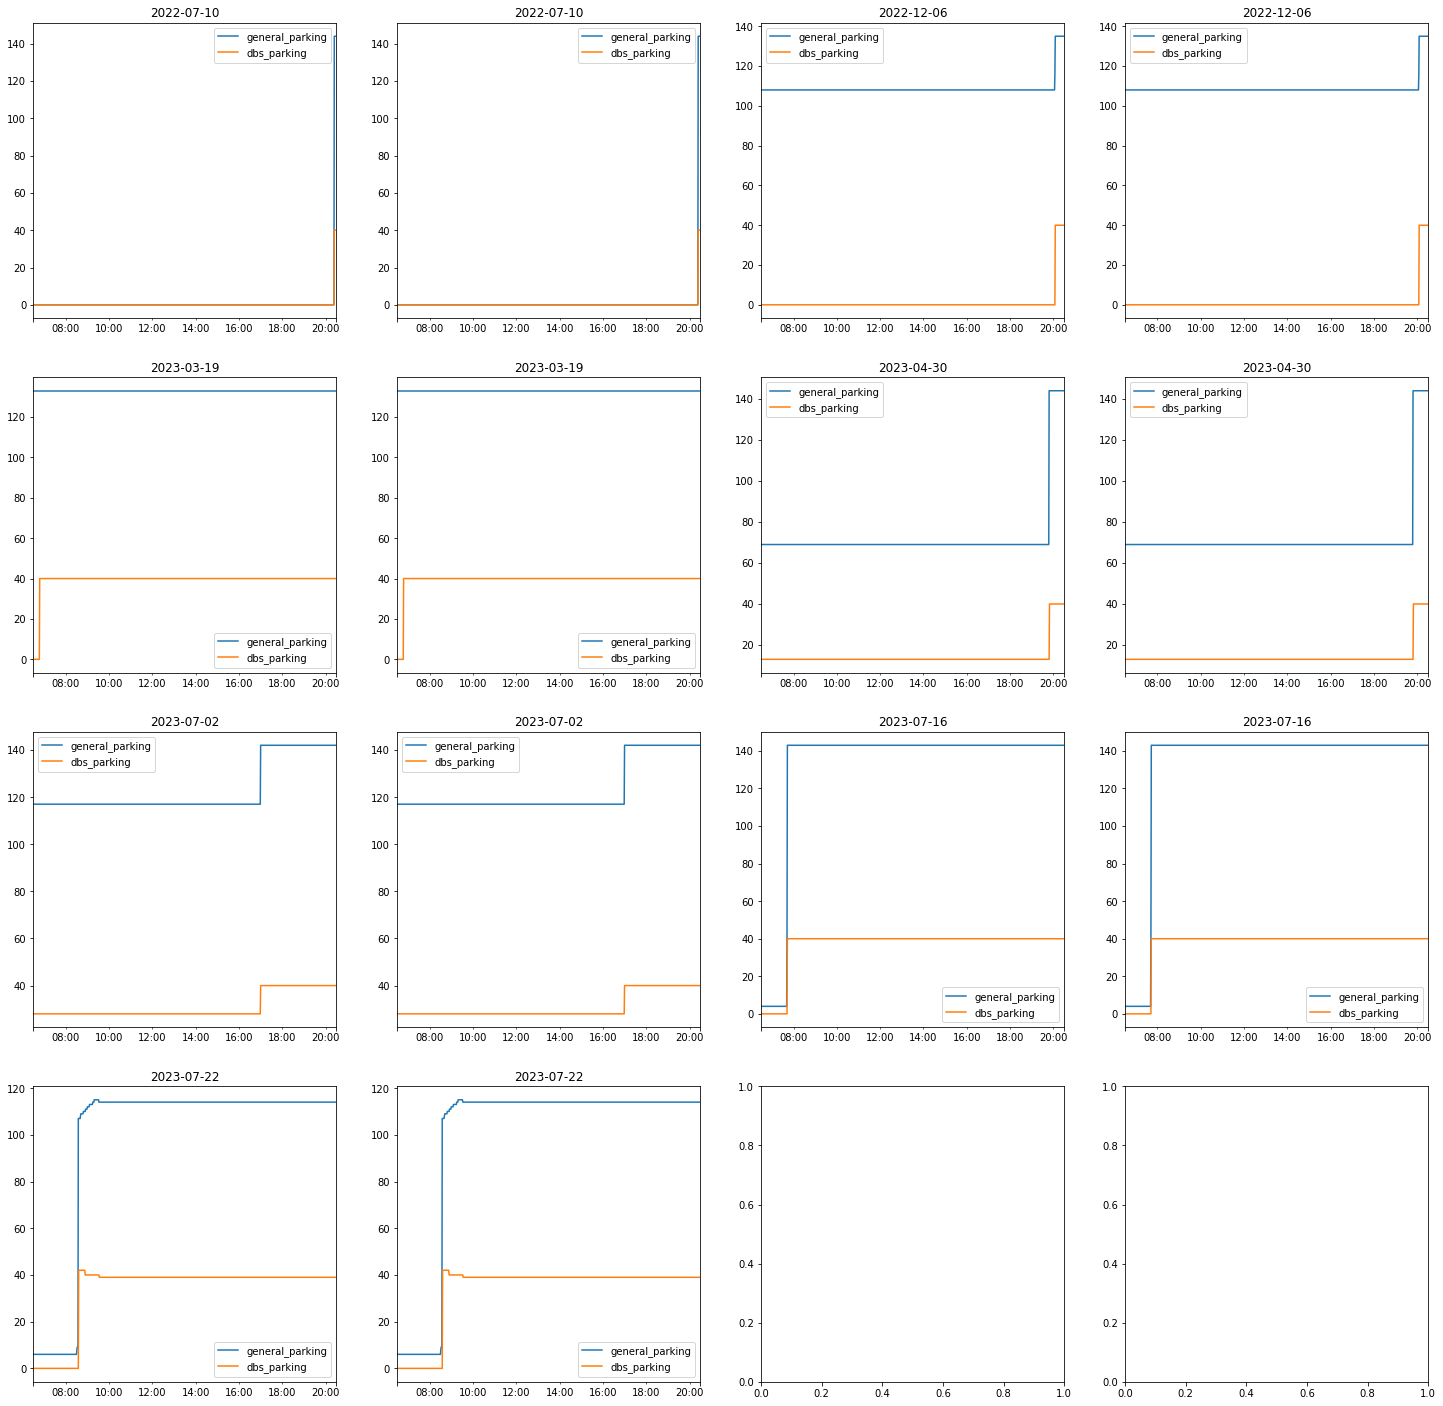

In [22]:
# Plot extrange days
n = len(list_of_days_with_lots_of_consecutive_equal_values)
fig, axes = plt.subplots(n//4 + 1, 4, figsize=(25, 25))
for idx, day in enumerate(list_of_days_with_lots_of_consecutive_equal_values):
    i = idx // 4
    j = idx % 4
    all_data[day].df.plot(ax=axes[i,j], title=day)

In [23]:
for k, v in days_with_meaningful_data.items():
    print(f'Number of days with meaningful data for {k}: {v}')

Number of days with meaningful data for general_parking: 272
Number of days with meaningful data for dbs_parking: 256


## Create the final .csv files with curated data

One .csv for each parking, as they differ in the number of meaningful days.

1. Create one dataframe for each parking containing only meaningful days
2. Create the .csv out of each dataframe and save to curated data
3. Create the script to automate this

In [43]:
a = all_data["2022-04-13"]

date: 2022-04-27
its_empty: {'general_parking': False, 'dbs_parking': False}
has_missing_data: {'general_parking': False, 'dbs_parking': False}
has_meaningful_data: {'general_parking': True, 'dbs_parking': True}


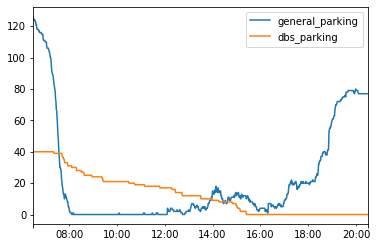

In [72]:
day = "2022-04-27"
for attr in all_data[day].__slots__:
    if attr in ["__weakref__", "df"]:
        continue
    print(f'{attr}:', all_data[day].__getattribute__(attr))
all_data[day].df.plot()
plt.show()

In [73]:
for v in all_data.values():
    if v.has_missing_data[GENERAL_PARKING]:
        print(f'Day {v.date} has no data for {GENERAL_PARKING}')
    if v.has_missing_data[DBS_PARKING]:
        print(f'Day {v.date} has no data for {DBS_PARKING}')

In [77]:
def create_new_df_with_same_structure_but_no_data(df):
    # Copy structure including data types but without the data
    df_structure_only = pd.DataFrame(columns=df.columns).astype(df.dtypes)

    # If the original DataFrame has a specialized index, replicate its structure
    if isinstance(df.index, pd.MultiIndex):
        # Example for MultiIndex (adjust as needed)
        df_structure_only.index = pd.MultiIndex(levels=[[]]*len(df.index.levels), codes=[[]]*len(df.index.levels), names=df.index.names)
    elif isinstance(df.index, pd.DatetimeIndex):
        # Example for DatetimeIndex (adjust as needed)
        df_structure_only.index = pd.DatetimeIndex([])
    else:
        # For other types of indices, you may set attributes similarly
        df_structure_only.index = df.index.__class__([])
        
    return df_structure_only

In [92]:
# Create the time series dataframe for the general parking and the DBS parking
df_general_parking = create_new_df_with_same_structure_but_no_data(all_data["2022-04-13"].df).drop(columns=[DBS_PARKING])
df_dbs_parking = create_new_df_with_same_structure_but_no_data(all_data["2022-04-13"].df).drop(columns=[GENERAL_PARKING])
for day in all_data.keys():

    # General parking checks
    empty = all_data[day].its_empty[GENERAL_PARKING]
    meaningful = all_data[day].has_meaningful_data[GENERAL_PARKING]
    missing_data = all_data[day].has_missing_data[GENERAL_PARKING]

    if meaningful and not empty and not missing_data:
        df_general_parking = pd.concat([df_general_parking, pd.DataFrame(all_data[day].df[GENERAL_PARKING])])
    else:
        print(f'Day {day} has no meaningful data for {GENERAL_PARKING}')        

    # DBS parking checks
    empty = all_data[day].its_empty[DBS_PARKING]
    meaningful = all_data[day].has_meaningful_data[DBS_PARKING]
    missing_data = all_data[day].has_missing_data[DBS_PARKING]

    if meaningful and not empty and not missing_data:
        df_dbs_parking = pd.concat([df_dbs_parking, pd.DataFrame(all_data[day].df[DBS_PARKING])])
    else:
        print(f'Day {day} has no meaningful data for {DBS_PARKING}')

Day 2022-04-13 has no meaningful data for dbs_parking
Day 2022-04-14 has no meaningful data for general_parking
Day 2022-04-14 has no meaningful data for dbs_parking
Day 2022-04-15 has no meaningful data for general_parking
Day 2022-04-15 has no meaningful data for dbs_parking
Day 2022-04-16 has no meaningful data for general_parking
Day 2022-04-16 has no meaningful data for dbs_parking
Day 2022-04-17 has no meaningful data for general_parking
Day 2022-04-17 has no meaningful data for dbs_parking
Day 2022-04-18 has no meaningful data for general_parking
Day 2022-04-18 has no meaningful data for dbs_parking
Day 2022-04-19 has no meaningful data for general_parking
Day 2022-04-19 has no meaningful data for dbs_parking
Day 2022-04-20 has no meaningful data for general_parking
Day 2022-04-20 has no meaningful data for dbs_parking
Day 2022-04-21 has no meaningful data for general_parking
Day 2022-04-21 has no meaningful data for dbs_parking
Day 2022-04-22 has no meaningful data for general_

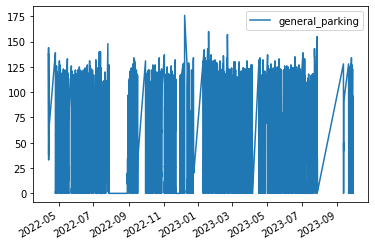

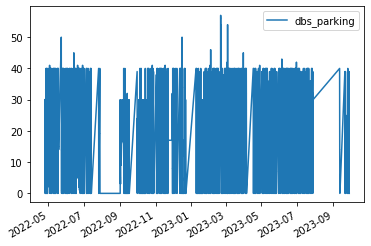

In [93]:
df_general_parking.plot()
plt.show()
df_dbs_parking.plot()
plt.show()

In [94]:
# Save curated data to csv
df_general_parking.to_csv(DATA_DIR_PATH / 'curated/general_parking.csv', sep=';')
df_dbs_parking.to_csv(DATA_DIR_PATH / 'curated/dbs_parking.csv', sep=';')

In [97]:
# Load the CSV file
df = pd.read_csv(DATA_DIR_PATH / 'curated/general_parking.csv', sep=';', parse_dates=[0], index_col=0)

# Display the first few rows to confirm
df

,general_parking
2022-04-13 06:30:00,138
2022-04-13 06:31:00,138
2022-04-13 06:32:00,138
2022-04-13 06:33:00,138
2022-04-13 06:34:00,136
...,...
2023-09-28 20:26:00,96
2023-09-28 20:27:00,96
2023-09-28 20:28:00,96
2023-09-28 20:29:00,96


# Final plots

Just with the print we can see how some days only have meaningless data on one of the parkings, so we can do 2 things:

1) Create two separated dataframes, each one with the meaningless days removed
2) Set the days and parkings with meaningless data to a certain value 

Better option the first one, so we can create another variable in the OneDayTimeSeries object that informs if the data is meaningless or not for that parking and based on that create two separated dataframes

In [288]:
# for day in all_data.keys():

#     contains_meaningless_data = {
#         GENERAL_PARKING: False,
#         DBS_PARKING: False
#     }

#     for col in all_data[day].df.columns:

#         if all_data[day].its_empty[col]:
#             continue
#         else:
#             min_occupation = all_data[day].df[col].min()
#             max_occupation = all_data[day].df[col].max()
#             diff = max_occupation - min_occupation
#             if diff < 10:
#                 #contains_meaningless_data[col].append(True)
#                 print(f'{day}: Contains meaningless data in {col}')
            
#             # # If is not empty, it contains meaningless data
#             # if contains_meaningless_data:
#             #     if all(contains_meaningless_data):
#             #         # Remove the data from the day
#             #         # print(f'{one_day_ts.date}: {contains_meaningless_data} Both columns have meaningless data')
#             #         all_data[day] = OneDayTimeSeries(date=day, its_empty=True, df=pd.DataFrame(columns=[GENERAL_PARKING, DBS_PARKING]))
#             #     elif any(contains_meaningless_data):
#             #         print(f'{day}: {contains_meaningless_data} Only one of the columns has meaningless data')
#             #         #all_data[one_day_ts.date] = OneDayTimeSeries(date=one_day_ts.date, its_empty=True, df=pd.DataFrame(columns=[GENERAL_PARKING, DBS_PARKING]))

So now create the DataFrames separated for each parking

In [306]:
general_list = []
dbs_list = []
for day in all_data.keys():
    
    for col, its_empty_one_parking in all_data[day].its_empty.items():
        
        if its_empty_one_parking:
            continue
        else:
            if col == GENERAL_PARKING:
                general_list.append(all_data[day].df.loc[:, [col]])
            elif col == DBS_PARKING:
                dbs_list.append(all_data[day].df.loc[:, [col]])
            else:
                raise Exception('Wrong column name')

df_general = pd.concat(general_list)
df_dbs = pd.concat(dbs_list)

In [307]:
list_with_days_with_one_parking_meaningful_and_the_other_not = []
total_days_general_meaninigful = 0
total_days_dbs_meaninigful = 0
for day in all_data.keys():
    if all_data[day].has_meaningful_data[GENERAL_PARKING]:
        total_days_general_meaninigful += 1
        if not all_data[day].has_meaningful_data[DBS_PARKING]:
            print(f'{day}: {GENERAL_PARKING} has meaningful data and {DBS_PARKING} does not')
            list_with_days_with_one_parking_meaningful_and_the_other_not.append(day)
    elif all_data[day].has_meaningful_data[DBS_PARKING]:
        
        if not all_data[day].has_meaningful_data[GENERAL_PARKING]:
            print(f'{day}: {DBS_PARKING} has meaningful data and {GENERAL_PARKING} does not')
            list_with_days_with_one_parking_meaningful_and_the_other_not.append(day)

    if all_data[day].has_meaningful_data[DBS_PARKING]:
        total_days_dbs_meaninigful += 1

print(f'Total days with meaningful data for {GENERAL_PARKING}: {total_days_general_meaninigful}')
print(f'Total days with meaningful data for {DBS_PARKING}: {total_days_dbs_meaninigful}')

2022-04-13: general_parking has meaningful data and dbs_parking does not
2022-07-14: general_parking has meaningful data and dbs_parking does not
2022-07-15: general_parking has meaningful data and dbs_parking does not
2022-07-18: general_parking has meaningful data and dbs_parking does not
2022-07-19: general_parking has meaningful data and dbs_parking does not
2022-07-20: general_parking has meaningful data and dbs_parking does not
2022-07-21: general_parking has meaningful data and dbs_parking does not
2022-07-22: general_parking has meaningful data and dbs_parking does not
2022-07-26: general_parking has meaningful data and dbs_parking does not
2022-07-27: general_parking has meaningful data and dbs_parking does not
2022-07-28: general_parking has meaningful data and dbs_parking does not
2022-08-29: general_parking has meaningful data and dbs_parking does not
2022-08-30: general_parking has meaningful data and dbs_parking does not
2022-08-31: general_parking has meaningful data and

In [308]:
len(list_with_days_with_one_parking_meaningful_and_the_other_not)

21

Now we inspect these extrange days

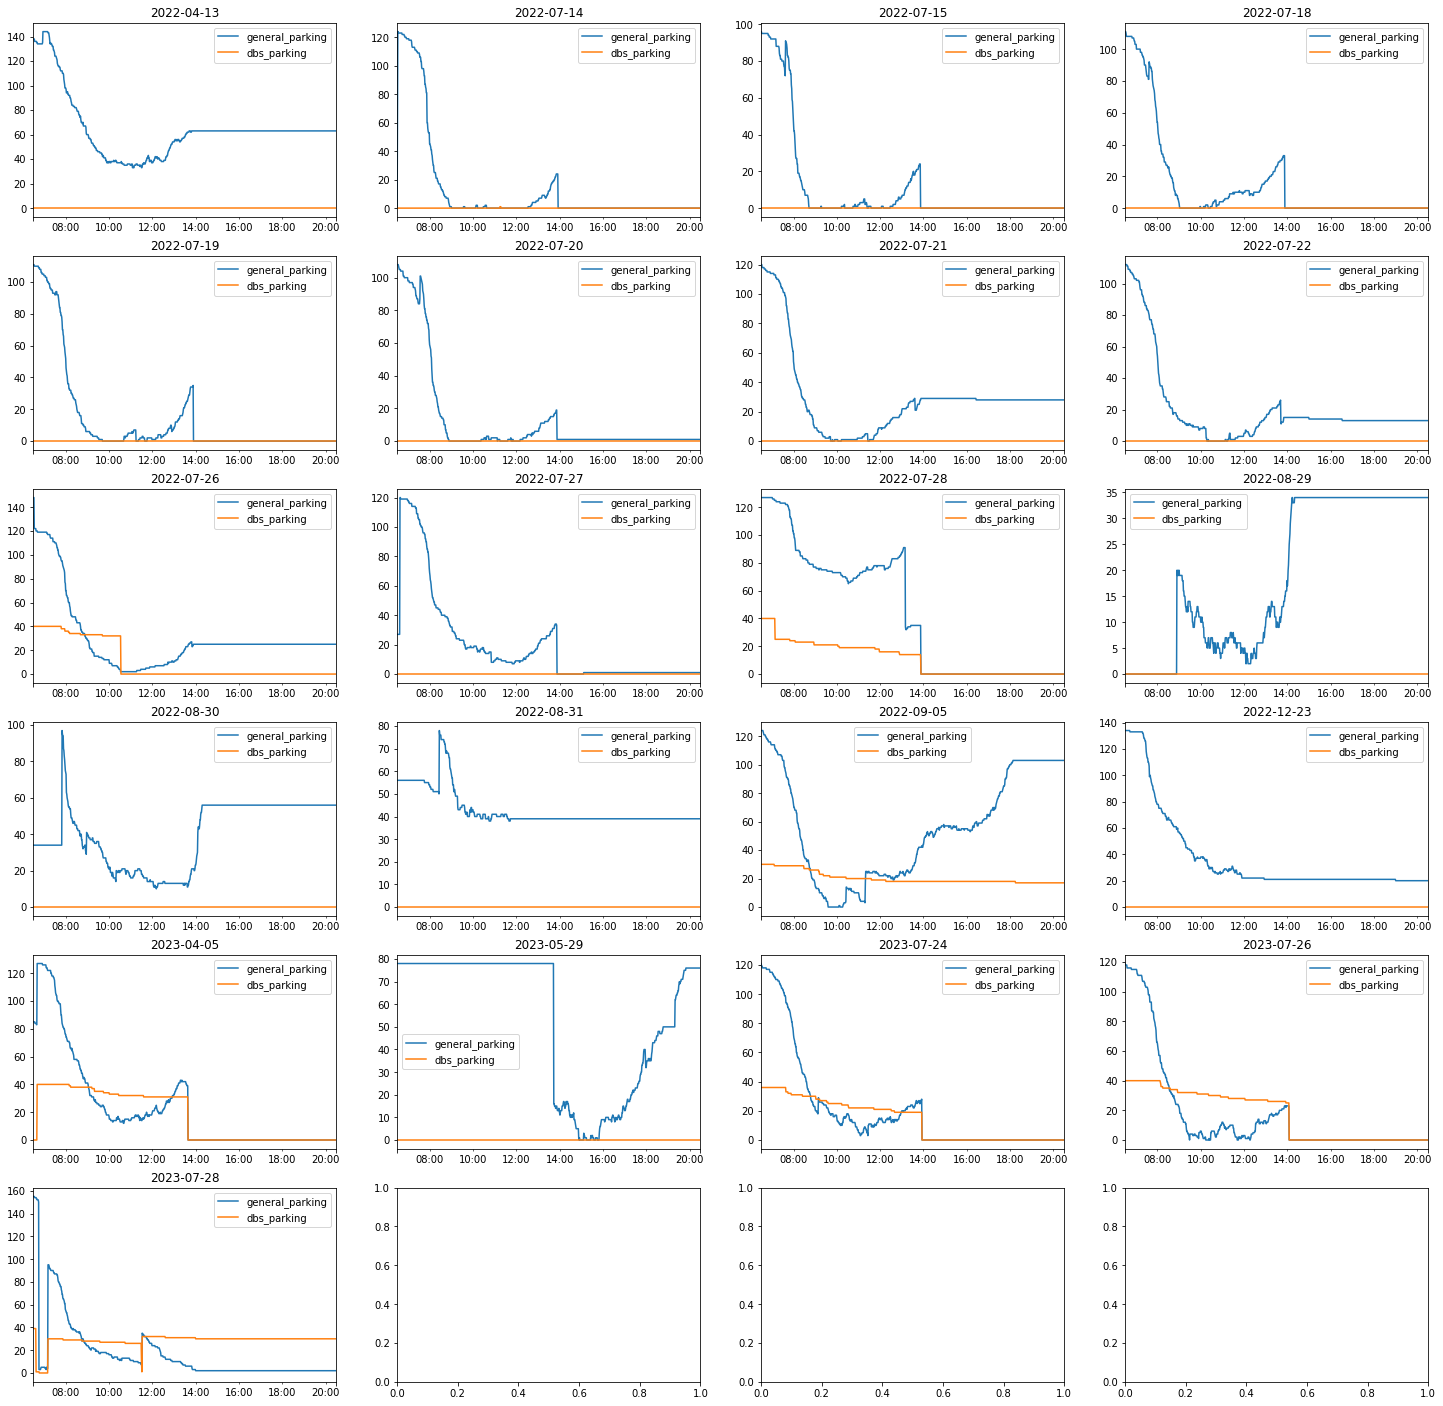

In [309]:
# Plot extrange days
n = len(list_with_days_with_one_parking_meaningful_and_the_other_not)
fig, axes = plt.subplots(n//4 + 1, 4, figsize=(25, 25))
for idx, day in enumerate(list_with_days_with_one_parking_meaningful_and_the_other_not):
    i = idx // 4
    j = idx % 4
    all_data[day].df.plot(ax=axes[i,j], title=day)

We can observer how some days have no info or are anomalous days, and others are normal days.

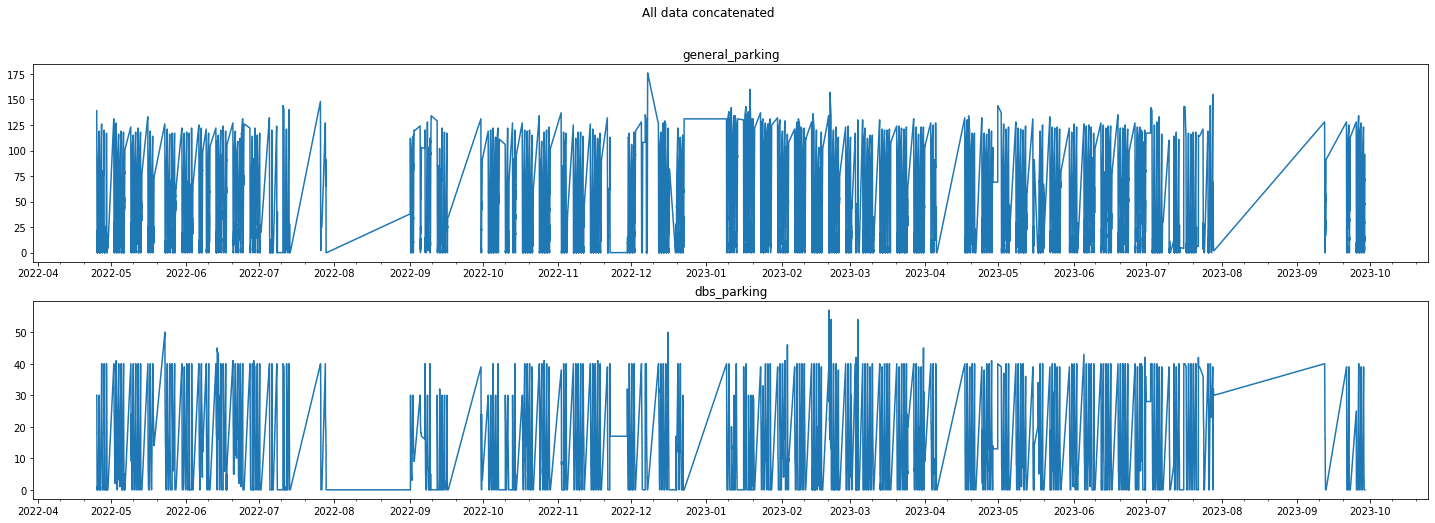

In [243]:
fig, axes = plt.subplots(2,1, figsize=(25, 8))
fig.suptitle(f'All data concatenated')
for idx, col in enumerate(df_all_data_concat.columns):
    axes[idx].plot(df_all_data_concat.index, df_all_data_concat[col], label=col)
    axes[idx].set_title(col)
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator())
    axes[idx].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(10, 20)))
    # axes[idx].set_xlim([datetime(2022, 10, 1), datetime(2023, 7, 1)])
plt.show()

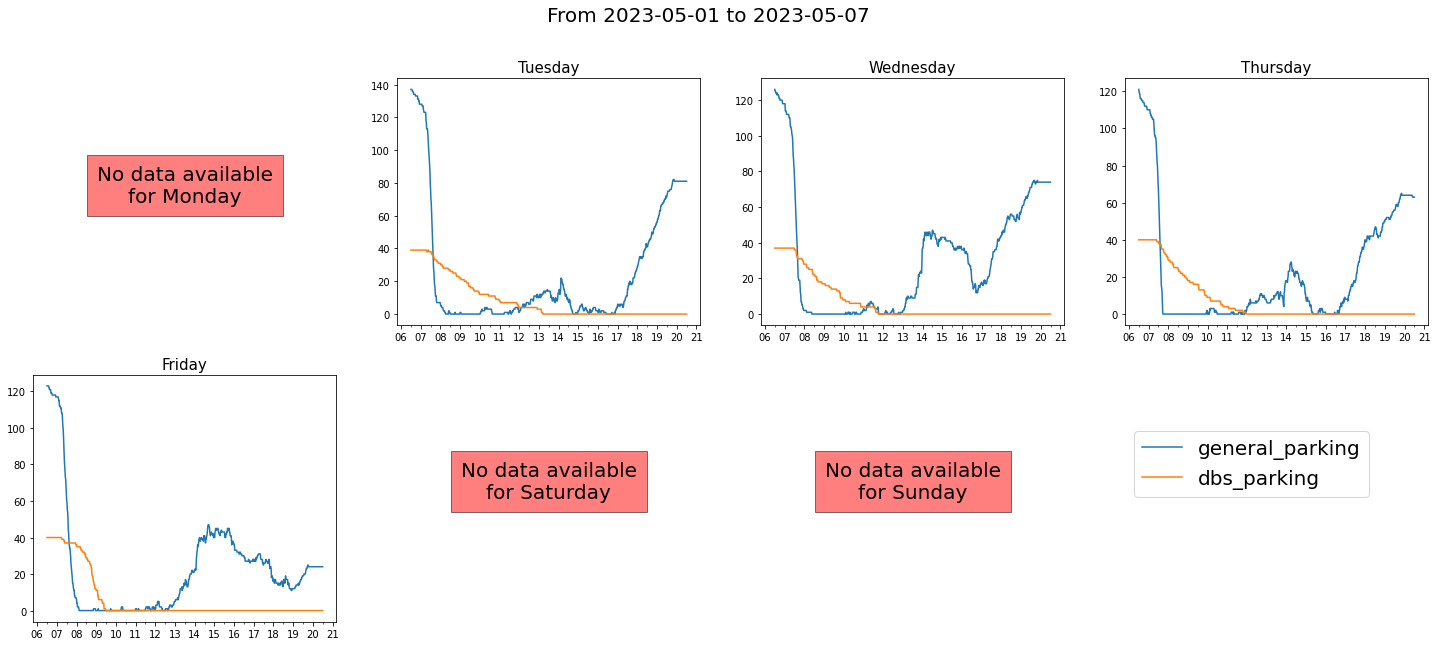

In [244]:
start, end = '2023-05-01', '2023-05-07'
daterange = pd.date_range(start, end)
width, height = 25, 10
fig, axes = plt.subplots(2,4, figsize=(25, 10))
fig.suptitle(f'From {start} to {end}', fontsize=20)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if i != 1 or j != 3:
            
            d = daterange[i*4 + j]
            df_today = df_all_data_concat.loc[d.strftime('%D')]
            current_weekday = WEEKDAYS[datetime.weekday(d)]

            if df_today.empty:
                #ax.remove()
                ax.set_axis_off()
                
                ax.text(0.5,0.5, f'No data available\nfor {current_weekday}',
                        fontsize=20, ha='center', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

            else:
                ax.plot(df_today.index, df_today)
                ax.set_title(current_weekday, fontsize=15)
                ax.xaxis.set_major_locator(mdates.HourLocator())
                ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=(30)))
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

        else:
            ax.remove()

fig.legend(df_today.columns, loc=(0.78, 0.23), fontsize=20)
plt.show()

As expected, the Monday (that was holiday) and the weekend has been eliminated

Now we have to try to use some models to check performance

### AutoCorrelation Function and Partial ACF (ACF and PACF)

- ACF => shows how past values affect the present value directly and indirectly (throught affecting intermediate values between past and present)
- PACF => shows the direct effect of a past value in the present value

If values of correlation fall in the blue are, it means these autocorrelation values are not significant

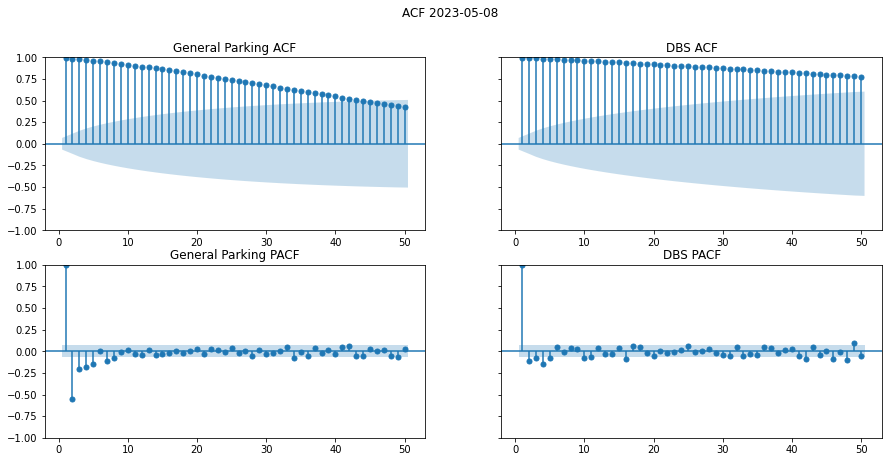

In [29]:
day = '2023-05-08'
fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharey=True)
fig.suptitle(f'ACF {day}')
plot_acf(all_data[day].df.general_parking, ax=axes[0,0], lags=50, title=f'General Parking ACF', zero=False)
plot_acf(all_data[day].df.dbs_parking, ax=axes[0,1], lags=50, title=f'DBS ACF', zero=False)
plot_pacf(all_data[day].df.general_parking, method='ols', ax=axes[1,0], lags=50, title=f'General Parking PACF', zero=False)
plot_pacf(all_data[day].df.dbs_parking, method='ols', ax=axes[1,1], lags=50, title=f'DBS PACF', zero=False)
plt.show()

For a random day, in general, the PACF shows how mainly the value right before the present one is the most correlated one

If we take all the time series as a whole:

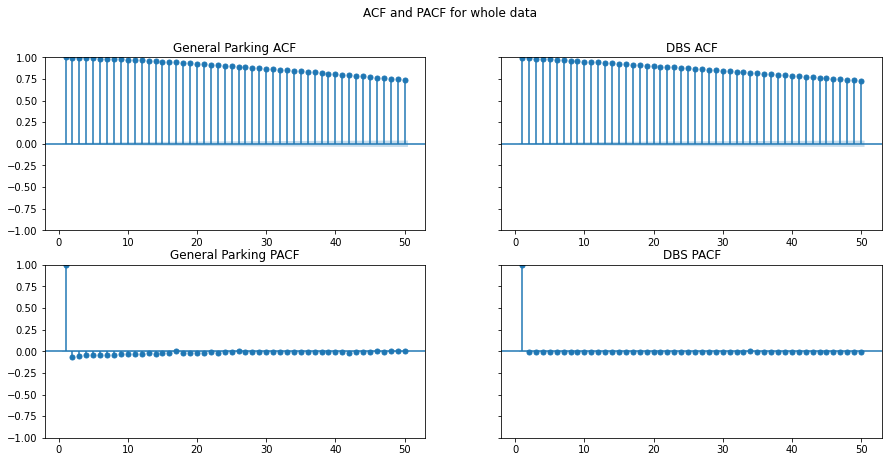

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharey=True)
fig.suptitle(f'ACF and PACF for whole data')
plot_acf(df_all_data_concat.general_parking, ax=axes[0,0], lags=50, title=f'General Parking ACF', zero=False)
plot_acf(df_all_data_concat.dbs_parking, ax=axes[0,1], lags=50, title=f'DBS ACF', zero=False)
plot_pacf(df_all_data_concat.general_parking, method='ols', ax=axes[1,0], lags=50, title=f'General Parking PACF', zero=False)
plot_pacf(df_all_data_concat.dbs_parking, method='ols', ax=axes[1,1], lags=50, title=f'DBS PACF', zero=False)
plt.show()

In [ ]:
# Plot ACF and PACF for each weekday
# for weekday in range(7):
#     fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
#     fig.suptitle(f'ACF and PACF for {WEEKDAYS[weekday]}')
#     for i, col in enumerate(df_all_data_concat.columns):
#         df_weekday = df_all_data_concat.loc[df_all_data_concat.index.weekday == weekday]
#         plot_acf(df_weekday[col], ax=axes[i], lags=50, title=f'{col} ACF', zero=False)
#         plot_pacf(df_weekday[col], method='ols', ax=axes[i], lags=50, title=f'{col} PACF', zero=False)
#     plt.show()

### Plot the mean and variance of each weekday

In [220]:
print('How much data do we have for each day?')
daterange = pd.date_range(start_date.date(), end_date.date())

amount_of_data_for_day = np.zeros(7)
# Iterate over the days
for d in tqdm(daterange):

    if all_data[d.strftime('%Y-%m-%d')].its_empty:
        continue
    else:
        amount_of_data_for_day[datetime.weekday(d)] += 1

for day, amount in zip(WEEKDAYS, amount_of_data_for_day):
    print(f'{day}: \t{amount} days available')    

How much data do we have for each day?


100%|██████████| 534/534 [00:00<00:00, 133557.44it/s]

Monday: 	0.0 days available
Tuesday: 	0.0 days available
Wednesday: 	0.0 days available
Thursday: 	0.0 days available
Friday: 	0.0 days available
Saturday: 	0.0 days available
Sunday: 	0.0 days available


We only have 2 and 4 days of data respectively for Saturdays and Sundays, so we do not predict those days

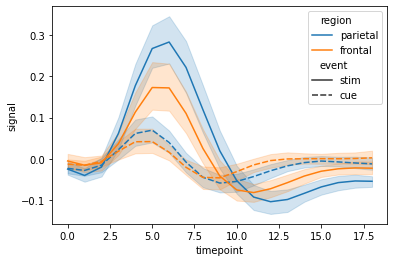

In [54]:
# Plot de cada dia de la semana, con la media de todos los dias de la semana
# como linea y en sombreado la varianza

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")
# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)
plt.show()

In [109]:
fmri['timepoint']

0       18
1       14
2       18
3       18
4       18
        ..
1059     8
1060     7
1061     7
1062     7
1063     0
Name: timepoint, Length: 1064, dtype: int64

In [222]:
def conv_time_float(value):
    vals = value.split(':')
    hours = float(vals[0])
    _, minutes = divmod(float(vals[1]), 60)
    minutes = minutes / 60.0
    return hours + minutes

In [223]:
day = '2023-05-05'
df_data_for_tsplot_one_day = all_data[day].df.reset_index()
df_data_for_tsplot_one_day.rename(columns = {'index':'time'}, inplace = True)
df_data_for_tsplot_one_day['time'] = df_data_for_tsplot_one_day['time'].apply(lambda x: x.strftime('%H:%M'))
df_data_for_tsplot_one_day['weekday'] = [WEEKDAYS[datetime.strptime(day, '%Y-%m-%d').weekday()] for _ in range(len(df_data_for_tsplot_one_day))]
#df_data_for_tsplot_one_day['timepoint'] = df_data_for_tsplot_one_day['time'].apply(lambda x: float(x.split(':')[0] + float(x.split(':')[1]/60)))
#df_data_for_tsplot_one_day['timepoint'] = df_data_for_tsplot_one_day['time'].apply(lambda x: float(f'x.split(':')[0]'))
df_data_for_tsplot_one_day['timepoint'] = df_data_for_tsplot_one_day['time'].apply(lambda x: conv_time_float(x))
df_data_for_tsplot_one_day

,time,general_parking,dbs_parking,weekday,timepoint
0,06:30,123,40,Friday,6.500000
1,06:31,123,40,Friday,6.516667
2,06:32,123,40,Friday,6.533333
3,06:33,123,40,Friday,6.550000
4,06:34,123,40,Friday,6.566667
...,...,...,...,...,...
836,20:26,24,0,Friday,20.433333
837,20:27,24,0,Friday,20.450000
838,20:28,24,0,Friday,20.466667
839,20:29,24,0,Friday,20.483333


In [225]:
df_data_for_tsplot = pd.DataFrame(columns=['time','general_parking', 'dbs_parking', 'time_str','weekday','timepoint'])
for day in tqdm(all_data.keys()):
    current_weekday = WEEKDAYS[datetime.strptime(day, '%Y-%m-%d').weekday()]
    if all_data[day].its_empty:
        continue
    elif current_weekday in ['Saturday', 'Sunday']:
        continue
    else:
        df_data_for_tsplot_one_day = all_data[day].df.reset_index()
        df_data_for_tsplot_one_day.rename(columns = {'index':'time'}, inplace = True)
        df_data_for_tsplot_one_day['time'] = df_data_for_tsplot_one_day['time'].apply(lambda x: x.time())
        df_data_for_tsplot_one_day['time_str'] = df_data_for_tsplot_one_day['time'].apply(lambda x: x.strftime('%H:%M'))
        df_data_for_tsplot_one_day['weekday'] = [current_weekday for _ in range(len(df_data_for_tsplot_one_day))]
        df_data_for_tsplot_one_day['timepoint'] = df_data_for_tsplot_one_day['time_str'].apply(lambda x: conv_time_float(x))
        df_data_for_tsplot = pd.concat([df_data_for_tsplot, df_data_for_tsplot_one_day])
        
df_data_for_tsplot.reset_index(inplace=True)
df_data_for_tsplot

100%|██████████| 534/534 [00:00<00:00, 23470.42it/s]


,index,time,general_parking,dbs_parking,time_str,weekday,timepoint


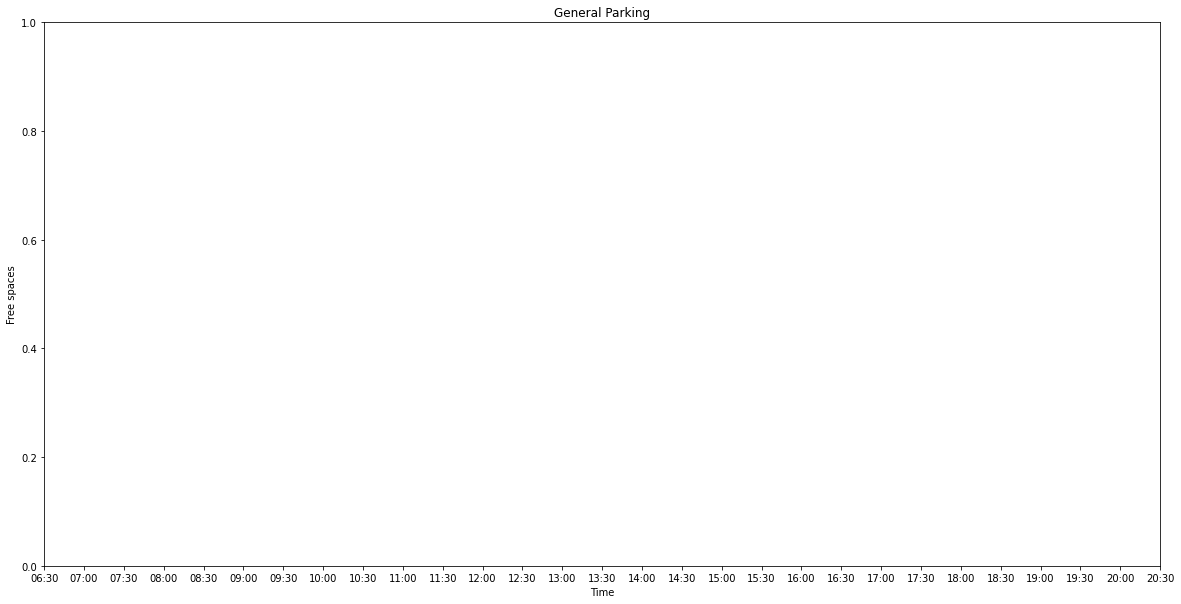

In [226]:
ticks_labels = []
for x in range(6, 21):
    for y in range(0,2):
        if x == 6:
            if y == 0:
                continue
        ticks_labels.append(f'{x:02}:{30*y:02}')
ticks_loc = [x*30 for x in range(0, 29)]

fig, ax = plt.subplots(1,1, figsize=(20, 10))
sns.lineplot(x='time_str', y="general_parking", hue="weekday", data=df_data_for_tsplot, ax=ax)

ax.set_xticks(ticks_loc, labels=ticks_labels)
ax.set_title('General Parking')
ax.set_xlabel('Time')
ax.set_ylabel('Free spaces')

# ticks_loc = deepcopy(ax.get_xticks()[::30])
# ticks_labels = deepcopy(ax.get_xticklabels()[::30])
# ticks_labels_formatted = deepcopy([x.get_text() for x in ticks_labels])
#ax.set_xticks(ticks_loc, labels=deepcopy(ticks_labels_formatted))
# ax.set_xticklabels([x.get_text() for x in ticks_labels], rotation=45, horizontalalignment='right')
# ax.set_xticks(ax.get_xticks()[::30])
# ax.set_xticklabels(ax.get_xticklabels()[::30])
#ax.set_xticklabels(ax.get_xticklabels()[::30], rotation=45, horizontalalignment='right')
plt.show()

Tenemos dos opciones para gestionar los datos en funcion del tipo de modelo:

- Si usamos un modelo no autoregresivo, podemos separar las columnas de mes y dia y convertirlas en categoricas. Ademas, podemos añadir la feature de definir si es dia de semana o fin de semana.
 
- Con un modelo autoregresivo, tendriamos que pegar las partes entre días y buscar una forma uniforme de numerar los timestamps

Friday


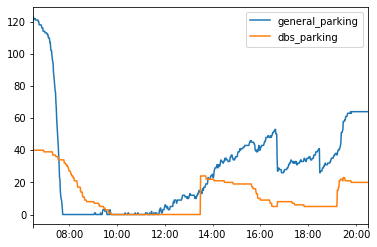

In [46]:
day = '2023-03-24'
print(WEEKDAYS[datetime.strptime(day, '%Y-%m-%d').weekday()])
df_all_data_concat.loc[day].plot()
plt.show()

# Decide how to treat the data for processing

We can chose to use the data from each day as an independent time series, creating different models to predict the occupation:
- Weekdays
- Weekend
- Days off
- Exam days

Or we can see each row as a datapoint with features of date and time. 